In [61]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # Dodajemy seaborn do stałego repertuaru

# --- Konfiguracja Ścieżki ---
# Dodaj folder 'src' do ścieżki, aby móc importować własne moduły
# Zakładamy, że notatnik jest w folderze 'notebooks/'
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
print(f"Dodano do ścieżki: {module_path}")

# --- Import Modułów Projektu ---
try:
    from src.data_loader import load_and_aggregate_exid, CELL_LENGTH_M, TIME_STEP_S
    from src.nasch_core import run_simulation, L as SIM_LENGTH_CELLS
    
    print("Pomyślnie zaimportowano moduły projektu (data_loader, nasch_core).")
    
    # Używamy f-stringa (f"...") aby poprawnie wyświetlić wartości
    print(f"Odczytano stałe fizyczne: Długość komórki = {CELL_LENGTH_M} m, Krok czasu = {TIME_STEP_S} s")

except ImportError as e:
    print(f"BŁĄD KRYTYCZNY: Nie można zaimportować modułów projektu. Sprawdź ścieżki i pliki. {e}")
except NameError as e:
    print(f"BŁĄD KRYTYCZNY: Moduły się zaimportowały, ale brakuje w nich stałych (CELL_LENGTH_M, TIME_STEP_S). {e}")

# --- Ustawienia Wykresów ---
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 8) # Domyślnie większe wykresy
print("\nUstawiono style wykresów. Komórka 1 gotowa.")

Dodano do ścieżki: /home/mikolaj/Desktop/isi5/dyskretne/traffic-simulation
Pomyślnie zaimportowano moduły projektu (data_loader, nasch_core).
Odczytano stałe fizyczne: Długość komórki = 7.5 m, Krok czasu = 1.0 s

Ustawiono style wykresów. Komórka 1 gotowa.


In [62]:
# Konfiguracja globalna
TARGET_RECORDING_ID = "05"
print(f"TARGET_RECORDING_ID = '{TARGET_RECORDING_ID}'")

TARGET_RECORDING_ID = '05'


In [63]:
print("Wczytywanie danych...")

rec_ids_do_analizy = [f"{i:02}" for i in range(1, 13)] 
print(f"Nagrania do analizy: {rec_ids_do_analizy}")

data_path = "../data/data/"

try:
    tracks_df, _ = load_and_aggregate_exid(data_dir=data_path, 
                                           rec_ids=rec_ids_do_analizy)
    
    if tracks_df is not None:
        print(f"\nWczytano {len(tracks_df)} pomiarów")
        print(f"Dostępne nagrania: {tracks_df['recordingId'].unique()}")
        print("\nPierwsze wiersze:")
        print(tracks_df.head())
    else:
        print("Błąd: nie wczytano danych")
        
except FileNotFoundError:
    print(f"Nie znaleziono plików w {data_path}")
except Exception as e:
    print(f"Błąd podczas wczytywania: {e}")

Wczytywanie danych...
Nagrania do analizy: ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
Załadowano nagranie ID: 01. Pojazdów: 877
Załadowano nagranie ID: 01. Pojazdów: 877
Załadowano nagranie ID: 02. Pojazdów: 183
Załadowano nagranie ID: 02. Pojazdów: 183
Załadowano nagranie ID: 03. Pojazdów: 960
Załadowano nagranie ID: 04. Pojazdów: 219
Załadowano nagranie ID: 03. Pojazdów: 960
Załadowano nagranie ID: 04. Pojazdów: 219
Załadowano nagranie ID: 05. Pojazdów: 478
Załadowano nagranie ID: 05. Pojazdów: 478
Załadowano nagranie ID: 06. Pojazdów: 381
Załadowano nagranie ID: 07. Pojazdów: 138
Załadowano nagranie ID: 06. Pojazdów: 381
Załadowano nagranie ID: 07. Pojazdów: 138
Załadowano nagranie ID: 08. Pojazdów: 204
Załadowano nagranie ID: 08. Pojazdów: 204
Załadowano nagranie ID: 09. Pojazdów: 370
Załadowano nagranie ID: 09. Pojazdów: 370
Załadowano nagranie ID: 10. Pojazdów: 284
Załadowano nagranie ID: 10. Pojazdów: 284
Załadowano nagranie ID: 11. Pojazdów: 668
Za

Mapa geometrii...
Wizualizacja dla 103306 punktów
Wizualizacja dla 103306 punktów


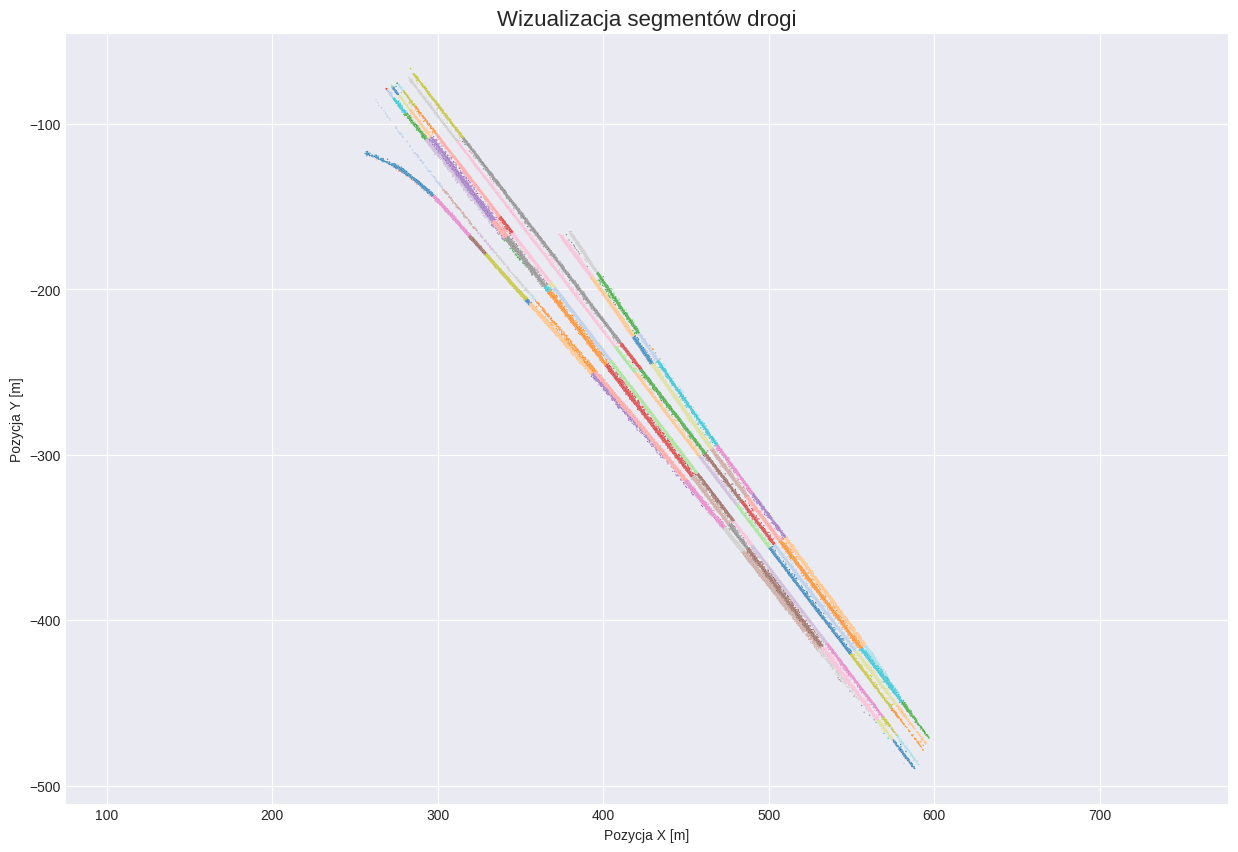

In [64]:
print("Mapa geometrii...")

if 'tracks_df' in locals() and tracks_df is not None:
    sample_df = tracks_df.sample(frac=0.05, random_state=42)
    print(f"Wizualizacja dla {len(sample_df)} punktów")
    
    plt.figure(figsize=(15, 10))
    sns.scatterplot(data=sample_df, x='xCenter', y='yCenter', 
                    hue='laneletId', palette='tab20', s=1, legend=False)
    
    plt.title('Wizualizacja segmentów drogi', fontsize=16)
    plt.xlabel('Pozycja X [m]')
    plt.ylabel('Pozycja Y [m]')
    plt.axis('equal')
    plt.show()
else:
    print("Brak danych")

Weryfikacja korków...
Znaleziono 12 nagrań


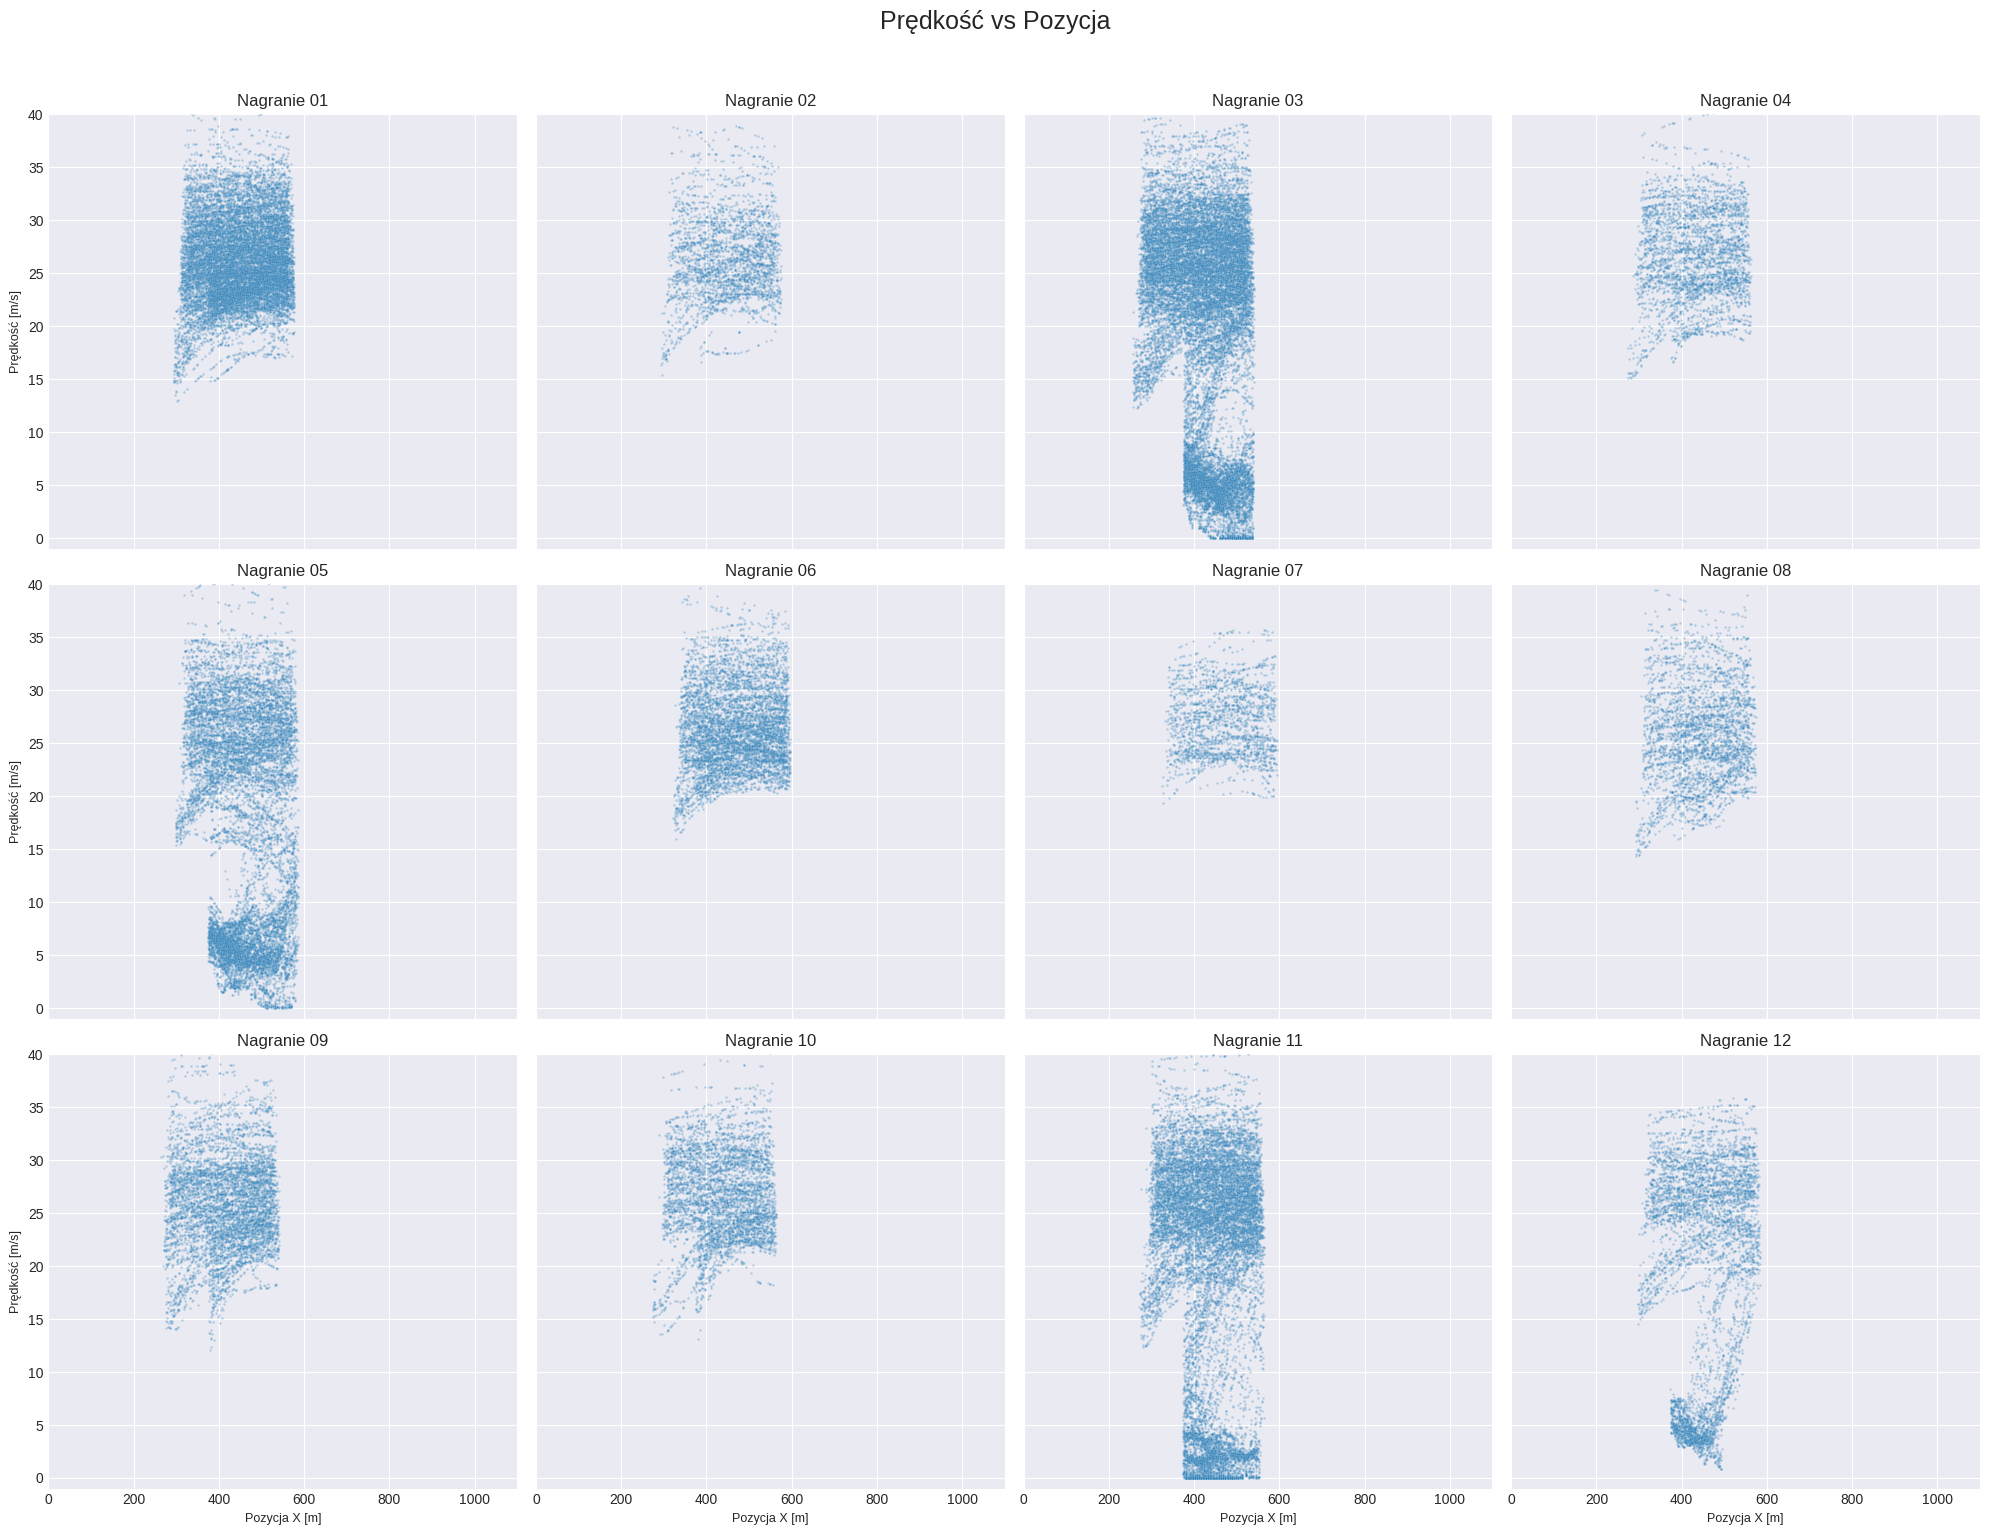

In [65]:
print("Weryfikacja korków...")

if 'tracks_df' in locals() and tracks_df is not None:
    unique_ids = sorted(tracks_df['recordingId'].unique())
    num_ids = len(unique_ids)
    
    cols = 4
    rows = (num_ids + cols - 1) // cols 
    
    print(f"Znaleziono {num_ids} nagrań")

    fig, axes = plt.subplots(rows, cols, figsize=(20, 5 * rows), sharex=True, sharey=True)
    ax_flat = axes.flat

    for i, rec_id in enumerate(unique_ids):
        ax = ax_flat[i] 
        df_rec = tracks_df[tracks_df['recordingId'] == rec_id]
        
        if df_rec.empty:
            ax.set_title(f"Nagranie {rec_id} (brak danych)")
            continue

        sample_rec_df = df_rec.sample(frac=0.05, random_state=42)
        sns.scatterplot(data=sample_rec_df, x='xCenter', y='speed_m_s',
                       s=3, alpha=0.3, ax=ax, legend=False)
        
        ax.set_title(f"Nagranie {rec_id}")
        ax.set_xlabel('Pozycja X [m]', fontsize=9)
        ax.set_ylabel('Prędkość [m/s]', fontsize=9)

    for j in range(i + 1, len(ax_flat)):
        ax_flat[j].set_visible(False)
        
    plt.xlim(0, 1100)
    plt.ylim(-1, 40) 
    plt.suptitle('Prędkość vs Pozycja', fontsize=18, y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("Brak danych")

# Kalibracja parametrów NaSch

Kalibracja parametrów modelu:
- v_max - maksymalna prędkość
- p - prawdopodobieństwo losowego hamowania

In [66]:
print("Wybór nagrania i laneleta\n")

print(f"Nagranie: {TARGET_RECORDING_ID}")

if 'tracks_df' in locals() and tracks_df is not None:
    df_target_rec = tracks_df[tracks_df['recordingId'] == TARGET_RECORDING_ID].copy()
    print(f"Pomiarów: {len(df_target_rec)}")
    print(f"Pojazdów: {df_target_rec['trackId'].nunique()}")
    print(f"Laneletów: {df_target_rec['laneletId'].nunique()}")
    
    lanelet_counts = df_target_rec.groupby('laneletId').size().sort_values(ascending=False)
    print("\nTop 10 laneletów:")
    print(lanelet_counts.head(10))
    
    test_lanelet_id = lanelet_counts.index[0]
    test_length_m = df_target_rec[df_target_rec['laneletId'] == test_lanelet_id]['xCenter'].max() - \
                     df_target_rec[df_target_rec['laneletId'] == test_lanelet_id]['xCenter'].min()
    
    print(f"\nWybrany lanelet: {test_lanelet_id}")
    print(f"Liczba pomiarów: {lanelet_counts.iloc[0]}")
    print(f"Długość: {test_length_m:.1f} m")
else:
    print("Błąd: brak danych")

Wybór nagrania i laneleta

Nagranie: 05
Pomiarów: 265302
Pojazdów: 478
Laneletów: 84

Top 10 laneletów:
laneletId
1918    23922
1703    23922
1709    16461
1687    11391
1913    10142
1697     9412
1957     9347
1706     8040
1951     7072
1696     6848
dtype: int64

Wybrany lanelet: 1918
Liczba pomiarów: 23922
Długość: 50.0 m


In [ ]:
print("Agregacja danych w biny czasowe\n")

if 'df_target_rec' in locals() and test_lanelet_id is not None:
    test_df = df_target_rec[df_target_rec['laneletId'] == test_lanelet_id].copy()
    
    FPS = 25
    TIME_BIN = 100
    
    print(f"FPS: {FPS}")
    print(f"Bin czasowy: {TIME_BIN} klatek ({TIME_BIN/FPS:.1f} s)")
    print(f"Długość komórki: {CELL_LENGTH_M} m")
    
    # Utwrzenie binów czasowych
    test_df['time_bin'] = (test_df['frame'] // TIME_BIN) * TIME_BIN
    
    segment_stats = []
    
    for time_bin, group in test_df.groupby('time_bin'):
        n_vehicles_in_frame = group['trackId'].nunique()
        
        # Średnia prędkość
        avg_speed = group['speed_m_s'].mean()
        
        # Oblicz zajętość (density) w komórkach na metr
        # Zakładamy, że każdy pojazd zajmuje około 1 komórki
        occupancy = n_vehicles_in_frame / (test_length_m / CELL_LENGTH_M)
        
        # Przepływ (flow) = density * velocity
        # Znormalizowane do pojazdów/(metr*sekunda)
        flow = n_vehicles_in_frame / (test_length_m * (TIME_BIN / FPS))
        
        segment_stats.append({
            'time_bin': time_bin,
            'time_s': time_bin / FPS,
            'n_vehicles': n_vehicles_in_frame,
            'avg_speed_m_s': avg_speed,
            'density': occupancy,  # pojazdy/komórkę (lub pojazdy/długość segmentu)
            'flow': flow  # pojazdy/(metr*sek)
        })
    
    segment_stats = pd.DataFrame(segment_stats)
    
    print(f"\nBinów czasowych: {len(segment_stats)}")
    print("\nStatystyki:")
    print(segment_stats.describe())
    print("\nPierwsze 5 binów:")
    print(segment_stats.head())
else:
    print("Błąd: brak danych")

Agregacja danych w biny czasowe

FPS: 25
Bin czasowy: 100 klatek (4.0 s)
Długość komórki: 7.5 m

Binów czasowych: 59

Statystyki:
          time_bin      time_s  n_vehicles  avg_speed_m_s    density  \
count    59.000000   59.000000   59.000000      59.000000  59.000000   
mean   2903.389831  116.135593    5.508475       9.257106   0.826824   
std    1723.365403   68.934616    2.351616       6.508817   0.352978   
min       0.000000    0.000000    1.000000       1.314067   0.150100   
25%    1450.000000   58.000000    4.500000       5.039711   0.675451   
50%    2900.000000  116.000000    6.000000       7.104648   0.900602   
75%    4350.000000  174.000000    7.000000       9.303489   1.050702   
max    5900.000000  236.000000   11.000000      26.502947   1.651103   

            flow  
count  59.000000  
mean    0.027561  
std     0.011766  
min     0.005003  
25%     0.022515  
50%     0.030020  
75%     0.035023  
max     0.055037  

Pierwsze 5 binów:
   time_bin  time_s  n_vehicles

Diagram fundamentalny



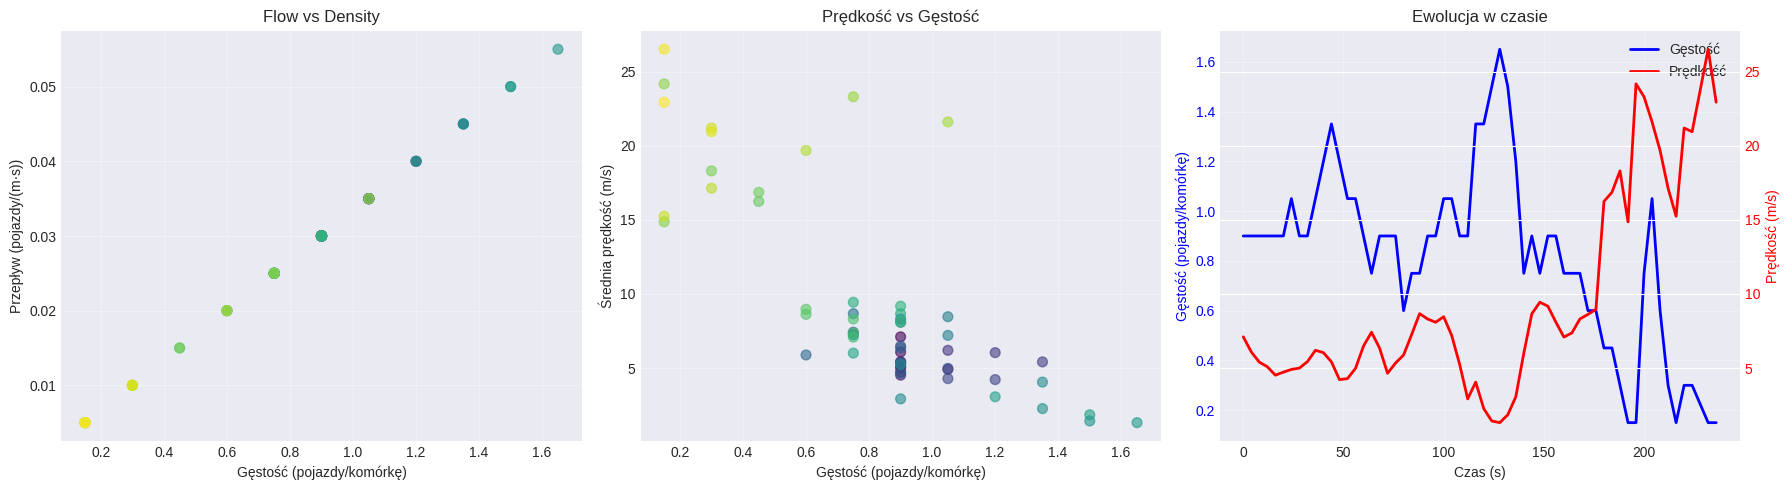


Max gęstość: 1.651
Max przepływ: 0.055037
Średnia prędkość: 9.26 m/s
Max prędkość: 26.50 m/s


In [68]:
print("Diagram fundamentalny\n")

if 'segment_stats' in locals() and segment_stats is not None:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Flow vs Density
    axes[0].scatter(segment_stats['density'], segment_stats['flow'], 
                    alpha=0.6, s=50, c=segment_stats['time_s'], cmap='viridis')
    axes[0].set_xlabel('Gęstość (pojazdy/komórkę)')
    axes[0].set_ylabel('Przepływ (pojazdy/(m·s))')
    axes[0].set_title('Flow vs Density')
    axes[0].grid(True, alpha=0.3)
    
    # Speed vs Density
    axes[1].scatter(segment_stats['density'], segment_stats['avg_speed_m_s'], 
                    alpha=0.6, s=50, c=segment_stats['time_s'], cmap='viridis')
    axes[1].set_xlabel('Gęstość (pojazdy/komórkę)')
    axes[1].set_ylabel('Średnia prędkość (m/s)')
    axes[1].set_title('Prędkość vs Gęstość')
    axes[1].grid(True, alpha=0.3)
    
    # Ewolucja w czasie
    ax3 = axes[2]
    ax3_twin = ax3.twinx()
    
    line1 = ax3.plot(segment_stats['time_s'], segment_stats['density'], 
                     'b-', label='Gęstość', linewidth=2)
    line2 = ax3_twin.plot(segment_stats['time_s'], segment_stats['avg_speed_m_s'], 
                          'r-', label='Prędkość', linewidth=2)
    
    ax3.set_xlabel('Czas (s)')
    ax3.set_ylabel('Gęstość (pojazdy/komórkę)', color='b')
    ax3_twin.set_ylabel('Prędkość (m/s)', color='r')
    ax3.set_title('Ewolucja w czasie')
    ax3.tick_params(axis='y', labelcolor='b')
    ax3_twin.tick_params(axis='y', labelcolor='r')
    ax3.grid(True, alpha=0.3)
    
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax3.legend(lines, labels, loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nMax gęstość: {segment_stats['density'].max():.3f}")
    print(f"Max przepływ: {segment_stats['flow'].max():.6f}")
    print(f"Średnia prędkość: {segment_stats['avg_speed_m_s'].mean():.2f} m/s")
    print(f"Max prędkość: {segment_stats['avg_speed_m_s'].max():.2f} m/s")
else:
    print("Błąd: brak danych")

In [69]:
print("Wyznaczenie parametrów v_max i p\n")

if 'test_df' in locals() and test_df is not None:
    
    # v_max
    test_df['v_nasch'] = (test_df['speed_m_s'] * TIME_STEP_S) / CELL_LENGTH_M
    v_max_empirical_float = test_df['v_nasch'].quantile(0.95)
    v_max = int(np.ceil(v_max_empirical_float))
    
    print("Kalibracja v_max:")
    print(f"  95-ty percentyl: {v_max_empirical_float:.2f} komórek/krok")
    print(f"  v_max: {v_max} komórek/krok")
    print(f"  Maksymalna prędkość: {v_max * CELL_LENGTH_M / TIME_STEP_S:.1f} m/s ({v_max * CELL_LENGTH_M / TIME_STEP_S * 3.6:.1f} km/h)")
    
    # p
    mean_speed = test_df['v_nasch'].mean()
    std_speed = test_df['v_nasch'].std()
    cv = std_speed / mean_speed if mean_speed > 0 else 0
    p_estimated = np.clip(cv * 0.5, 0.05, 0.5)
    
    print("\nKalibracja p:")
    print(f"  Średnia prędkość: {mean_speed:.2f} komórek/krok")
    print(f"  Odchylenie standardowe: {std_speed:.2f}")
    print(f"  Współczynnik zmienności: {cv:.3f}")
    print(f"  Estymowane p: {p_estimated:.3f}")
    
    # Analiza hamowania
    test_df_sorted = test_df.sort_values(['trackId', 'frame'])
    test_df_sorted['speed_change'] = test_df_sorted.groupby('trackId')['v_nasch'].diff()
    deceleration_events = (test_df_sorted['speed_change'] < -0.5).sum()
    total_events = len(test_df_sorted[test_df_sorted['speed_change'].notna()])
    p_from_deceleration = deceleration_events / total_events if total_events > 0 else 0.15
    
    print(f"\n  Analiza hamowania:")
    print(f"  Zdarzenia hamowania: {deceleration_events}")
    print(f"  Łączna liczba zdarzeń: {total_events}")
    print(f"  p z hamowania: {p_from_deceleration:.3f}")
    
    p_final = (p_estimated + p_from_deceleration) / 2
    p_final = np.clip(p_final, 0.05, 0.5)
    
    print(f"\nFINALNE PARAMETRY:")
    print(f"  v_max = {v_max} komórek/krok")
    print(f"  p = {p_final:.3f}")
    print(f"\nInterpretacja:")
    print(f"  Max prędkość: {v_max * CELL_LENGTH_M / TIME_STEP_S * 3.6:.0f} km/h")
    print(f"  Hamowanie co ~{1/p_final:.1f} krok")
    
    K = p_final
else:
    print("Błąd: brak danych")

Wyznaczenie parametrów v_max i p

Kalibracja v_max:
  95-ty percentyl: 2.35 komórek/krok
  v_max: 3 komórek/krok
  Maksymalna prędkość: 22.5 m/s (81.0 km/h)

Kalibracja p:
  Średnia prędkość: 0.86 komórek/krok
  Odchylenie standardowe: 0.60
  Współczynnik zmienności: 0.706
  Estymowane p: 0.353

  Analiza hamowania:
  Zdarzenia hamowania: 0
  Łączna liczba zdarzeń: 23837
  p z hamowania: 0.000

FINALNE PARAMETRY:
  v_max = 3 komórek/krok
  p = 0.176

Interpretacja:
  Max prędkość: 81 km/h
  Hamowanie co ~5.7 krok


Rozkłady prędkości



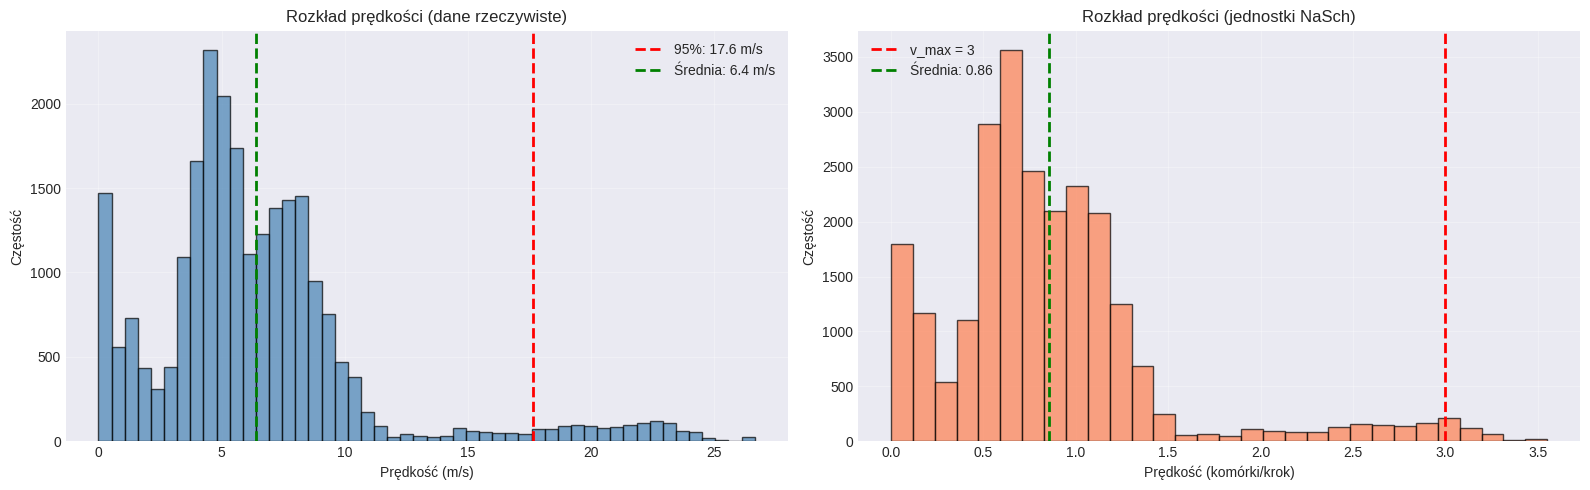

Statystyki:
  Min: 0.00 m/s
  25%: 4.05 m/s
  Mediana: 5.56 m/s
  75%: 7.99 m/s
  95%: 17.62 m/s
  Max: 26.63 m/s


In [70]:
print("Rozkłady prędkości\n")

if 'test_df' in locals() and 'v_max' in locals():
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    # Histogram m/s
    axes[0].hist(test_df['speed_m_s'], bins=50, alpha=0.7, color='steelblue', edgecolor='black')
    axes[0].axvline(test_df['speed_m_s'].quantile(0.95), color='red', linestyle='--', 
                    linewidth=2, label=f'95%: {test_df["speed_m_s"].quantile(0.95):.1f} m/s')
    axes[0].axvline(test_df['speed_m_s'].mean(), color='green', linestyle='--', 
                    linewidth=2, label=f'Średnia: {test_df["speed_m_s"].mean():.1f} m/s')
    axes[0].set_xlabel('Prędkość (m/s)')
    axes[0].set_ylabel('Częstość')
    axes[0].set_title('Rozkład prędkości (dane rzeczywiste)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Histogram jednostki NaSch
    axes[1].hist(test_df['v_nasch'], bins=30, alpha=0.7, color='coral', edgecolor='black')
    axes[1].axvline(v_max, color='red', linestyle='--', 
                    linewidth=2, label=f'v_max = {v_max}')
    axes[1].axvline(test_df['v_nasch'].mean(), color='green', linestyle='--', 
                    linewidth=2, label=f'Średnia: {test_df["v_nasch"].mean():.2f}')
    axes[1].set_xlabel('Prędkość (komórki/krok)')
    axes[1].set_ylabel('Częstość')
    axes[1].set_title('Rozkład prędkości (jednostki NaSch)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("Statystyki:")
    print(f"  Min: {test_df['speed_m_s'].min():.2f} m/s")
    print(f"  25%: {test_df['speed_m_s'].quantile(0.25):.2f} m/s")
    print(f"  Mediana: {test_df['speed_m_s'].median():.2f} m/s")
    print(f"  75%: {test_df['speed_m_s'].quantile(0.75):.2f} m/s")
    print(f"  95%: {test_df['speed_m_s'].quantile(0.95):.2f} m/s")
    print(f"  Max: {test_df['speed_m_s'].max():.2f} m/s")
else:
    print("Błąd: brak danych")

# Kalibracja dla drogi bez korków

Testowanie na drodze złożonej z laneletów: 1765, 1760, 1751, 1754

In [76]:
print("Dane dla wybranych laneletów\n")

target_lanelets = [1765, 1760, 1751, 1754]
print(f"Lanelets: {target_lanelets}")

if 'df_target_rec' in locals() and df_target_rec is not None:
    freeflow_df = df_target_rec[df_target_rec['laneletId'].isin(target_lanelets)].copy()
    
    print(f"Pomiarów: {len(freeflow_df)}")
    print(f"Pojazdów: {freeflow_df['trackId'].nunique()}")
    
    # sprawdzam ile danych jest na każdym laneecie
    for lid in target_lanelets:
        count = len(freeflow_df[freeflow_df['laneletId'] == lid])
        print(f"  Lanelet {lid}: {count} pomiarów")
    
    # podstawowe statystyki prędkości
    print(f"\nPrędkość:")
    print(f"  Średnia: {freeflow_df['speed_m_s'].mean():.2f} m/s")
    print(f"  Max: {freeflow_df['speed_m_s'].max():.2f} m/s")
    print(f"  Min: {freeflow_df['speed_m_s'].min():.2f} m/s")
else:
    print("Brak danych")

Dane dla wybranych laneletów

Lanelets: [1765, 1760, 1751, 1754]
Pomiarów: 5836
Pojazdów: 51
  Lanelet 1765: 219 pomiarów
  Lanelet 1760: 2371 pomiarów
  Lanelet 1751: 985 pomiarów
  Lanelet 1754: 2261 pomiarów

Prędkość:
  Średnia: 18.62 m/s
  Max: 25.02 m/s
  Min: 14.66 m/s


In [77]:
print("Agregacja dla drogi bez korków\n")

if 'freeflow_df' in locals() and freeflow_df is not None:
    # szacuję całkowitą długość drogi
    total_length_m = 0
    for lid in target_lanelets:
        lane_data = freeflow_df[freeflow_df['laneletId'] == lid]
        if len(lane_data) > 0:
            length = lane_data['xCenter'].max() - lane_data['xCenter'].min()
            total_length_m += length
            print(f"Lanelet {lid}: {length:.1f} m")
    
    print(f"\nCałkowita długość: {total_length_m:.1f} m")
    
    FPS = 25
    TIME_BIN = 100
    
    freeflow_df['time_bin'] = (freeflow_df['frame'] // TIME_BIN) * TIME_BIN
    
    freeflow_stats = []
    for time_bin, group in freeflow_df.groupby('time_bin'):
        n_vehicles = group['trackId'].nunique()
        avg_speed = group['speed_m_s'].mean()
        density = n_vehicles / (total_length_m / CELL_LENGTH_M)
        flow = n_vehicles / (total_length_m * (TIME_BIN / FPS))
        
        freeflow_stats.append({
            'time_bin': time_bin,
            'time_s': time_bin / FPS,
            'n_vehicles': n_vehicles,
            'avg_speed_m_s': avg_speed,
            'density': density,
            'flow': flow
        })
    
    freeflow_stats = pd.DataFrame(freeflow_stats)
    
    print(f"\nBinów: {len(freeflow_stats)}")
    print("\nStatystyki:")
    print(freeflow_stats.describe())
else:
    print("Brak danych")

Agregacja dla drogi bez korków

Lanelet 1765: 3.6 m
Lanelet 1760: 25.6 m
Lanelet 1751: 10.8 m
Lanelet 1754: 22.5 m

Całkowita długość: 62.5 m

Binów: 35

Statystyki:
          time_bin      time_s  n_vehicles  avg_speed_m_s    density  \
count    35.000000   35.000000   35.000000      35.000000  35.000000   
mean   3045.714286  121.828571    3.085714      18.850814   0.370531   
std    1721.036428   68.841457    2.105615       1.610510   0.252841   
min       0.000000    0.000000    1.000000      15.809616   0.120079   
25%    1900.000000   76.000000    1.000000      17.871178   0.120079   
50%    3000.000000  120.000000    3.000000      18.745361   0.360238   
75%    4550.000000  182.000000    4.000000      19.649384   0.480317   
max    5900.000000  236.000000    7.000000      23.767279   0.840555   

            flow  
count  35.000000  
mean    0.012351  
std     0.008428  
min     0.004003  
25%     0.004003  
50%     0.012008  
75%     0.016011  
max     0.028019  


Wykresy dla drogi bez korków



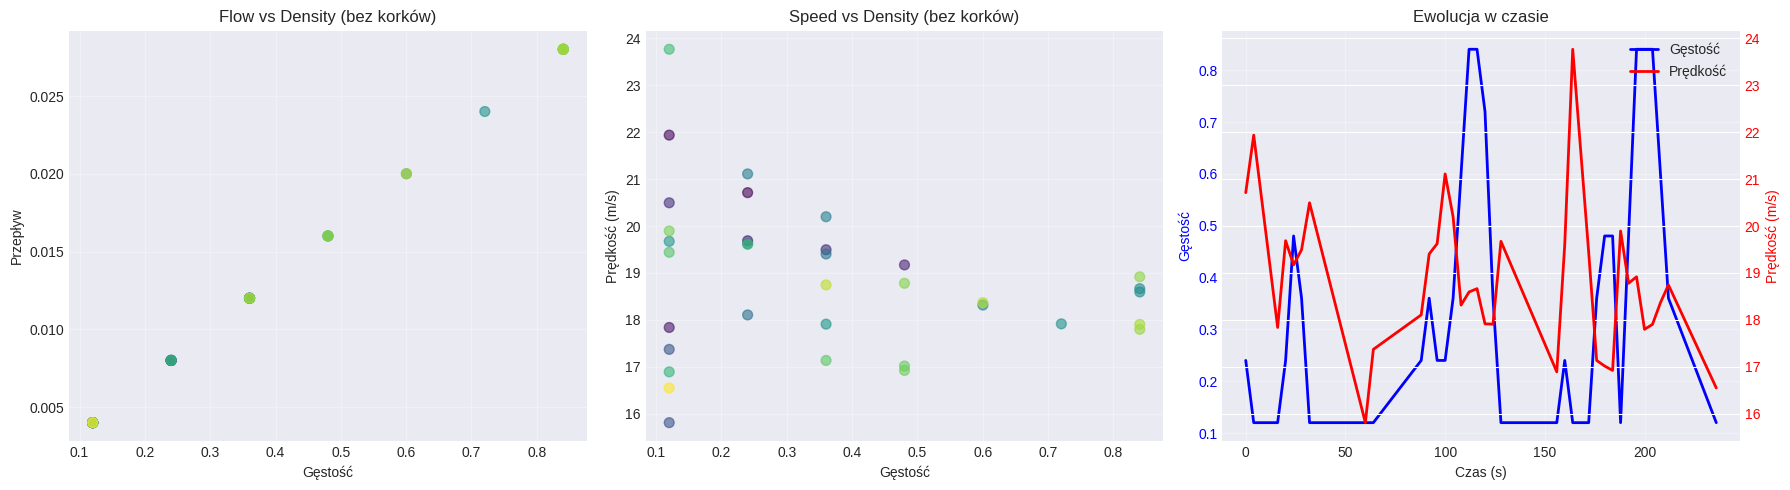

Max gęstość: 0.841
Max przepływ: 0.028019
Średnia prędkość: 18.85 m/s


In [78]:
print("Wykresy dla drogi bez korków\n")

if 'freeflow_stats' in locals() and freeflow_stats is not None:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    axes[0].scatter(freeflow_stats['density'], freeflow_stats['flow'], 
                    alpha=0.6, s=50, c=freeflow_stats['time_s'], cmap='viridis')
    axes[0].set_xlabel('Gęstość')
    axes[0].set_ylabel('Przepływ')
    axes[0].set_title('Flow vs Density (bez korków)')
    axes[0].grid(True, alpha=0.3)
    
    axes[1].scatter(freeflow_stats['density'], freeflow_stats['avg_speed_m_s'], 
                    alpha=0.6, s=50, c=freeflow_stats['time_s'], cmap='viridis')
    axes[1].set_xlabel('Gęstość')
    axes[1].set_ylabel('Prędkość (m/s)')
    axes[1].set_title('Speed vs Density (bez korków)')
    axes[1].grid(True, alpha=0.3)
    
    ax3 = axes[2]
    ax3_twin = ax3.twinx()
    line1 = ax3.plot(freeflow_stats['time_s'], freeflow_stats['density'], 
                     'b-', label='Gęstość', linewidth=2)
    line2 = ax3_twin.plot(freeflow_stats['time_s'], freeflow_stats['avg_speed_m_s'], 
                          'r-', label='Prędkość', linewidth=2)
    ax3.set_xlabel('Czas (s)')
    ax3.set_ylabel('Gęstość', color='b')
    ax3_twin.set_ylabel('Prędkość (m/s)', color='r')
    ax3.set_title('Ewolucja w czasie')
    ax3.tick_params(axis='y', labelcolor='b')
    ax3_twin.tick_params(axis='y', labelcolor='r')
    ax3.grid(True, alpha=0.3)
    
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax3.legend(lines, labels, loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Max gęstość: {freeflow_stats['density'].max():.3f}")
    print(f"Max przepływ: {freeflow_stats['flow'].max():.6f}")
    print(f"Średnia prędkość: {freeflow_stats['avg_speed_m_s'].mean():.2f} m/s")
else:
    print("Brak danych")

In [80]:
print("Kalibracja parametrów (droga bez korków)\n")

if 'freeflow_df' in locals() and freeflow_df is not None:
    freeflow_df['v_nasch'] = (freeflow_df['speed_m_s'] * TIME_STEP_S) / CELL_LENGTH_M
    
    v_max_ff_float = freeflow_df['v_nasch'].quantile(0.95)
    v_max_ff = int(np.ceil(v_max_ff_float))
    
    print("v_max:")
    print(f"  95 percentyl: {v_max_ff_float:.2f}")
    print(f"  v_max: {v_max_ff}")
    print(f"  Prędkość: {v_max_ff * CELL_LENGTH_M / TIME_STEP_S:.1f} m/s ({v_max_ff * CELL_LENGTH_M / TIME_STEP_S * 3.6:.1f} km/h)")
    
    mean_speed_ff = freeflow_df['v_nasch'].mean()
    std_speed_ff = freeflow_df['v_nasch'].std()
    cv_ff = std_speed_ff / mean_speed_ff if mean_speed_ff > 0 else 0
    p_estimated_ff = np.clip(cv_ff * 0.5, 0.05, 0.5)
    
    print("\np:")
    print(f"  Średnia prędkość: {mean_speed_ff:.2f}")
    print(f"  Estymowane p: {p_estimated_ff:.3f}")
    
    freeflow_df_sorted = freeflow_df.sort_values(['trackId', 'frame'])
    freeflow_df_sorted['speed_change'] = freeflow_df_sorted.groupby('trackId')['v_nasch'].diff()
    decel_events_ff = (freeflow_df_sorted['speed_change'] < -0.5).sum()
    total_events_ff = len(freeflow_df_sorted[freeflow_df_sorted['speed_change'].notna()])
    p_from_decel_ff = decel_events_ff / total_events_ff if total_events_ff > 0 else 0.15
    
    print(f"\n  Hamowania: {decel_events_ff}/{total_events_ff}")
    print(f"  p z hamowania: {p_from_decel_ff:.3f}")
    
    p_final_ff = (p_estimated_ff + p_from_decel_ff) / 2
    p_final_ff = np.clip(p_final_ff, 0.05, 0.5)
    
    print(f"\nParametry finalne (droga bez korków):")
    print(f"  v_max = {v_max_ff}")
    print(f"  p = {p_final_ff:.3f}")
    
    print(f"\nPorównanie z drogą z korkami:")
    print(f"  v_max: {v_max} (z korkami) vs {v_max_ff} (bez korków)")
    print(f"  p: {p_final:.3f} (z korkami) vs {p_final_ff:.3f} (bez korków)")
else:
    print("Brak danych")

Kalibracja parametrów (droga bez korków)

v_max:
  95 percentyl: 2.86
  v_max: 3
  Prędkość: 22.5 m/s (81.0 km/h)

p:
  Średnia prędkość: 2.48
  Estymowane p: 0.050

  Hamowania: 0/5785
  p z hamowania: 0.000

Parametry finalne (droga bez korków):
  v_max = 3
  p = 0.050

Porównanie z drogą z korkami:
  v_max: 3 (z korkami) vs 3 (bez korków)
  p: 0.176 (z korkami) vs 0.050 (bez korków)
